Q=AW_Q 
K=AW_K
V=AW_V

In [12]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [13]:
def sequence_mask(X, valid_len, value = 0):
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype = torch.float32, device = X.device)[None, :] < valid_len[:, None]
    X[~mask] = value # ~mask取反，将无效特征位置设为value（默认0）
    return X

生成0到maxlen-1的序列（特征位置索引），形状为(1, maxlen)
arange = torch.arange(maxlen, dtype=torch.float32, device=X.device)[None, :]

valid_len[:, None] 将(6,)的valid_len扩展为(6, 1)，适配特征维度
mask = arange < valid_len[:, None]  # 形状为(6, maxlen)，即(6, 4)

In [14]:
def masked_softmax(X, valid_lens):
    if valid_lens is None:
        return nn.functional.softmax(X, dim = -1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value = -1e6)
        return nn.functional.softmax(X.reshape(shape), dim = -1)

In [15]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.6412, 0.3588, 0.0000, 0.0000],
         [0.4480, 0.5520, 0.0000, 0.0000]],

        [[0.2628, 0.2901, 0.4471, 0.0000],
         [0.3599, 0.4165, 0.2237, 0.0000]]])

In [16]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2533, 0.3205, 0.4261, 0.0000]],

        [[0.4771, 0.5229, 0.0000, 0.0000],
         [0.2264, 0.3520, 0.1808, 0.2408]]])

若 valid_lens 是 1D（每个样本一个有效长度）：通过 repeat_interleave 重复 shape[1] 次（shape[1] 是序列长度），让每个位置都对应相同的有效长度。
valid_lens 是 1D 张量，形状为 (batch_size,)，例如 valid_lens = torch.tensor([2, 3])（表示 batch 中两个样本的有效长度分别为 2 和 3）。
shape[1] 是输入 X 的序列长度（第二维），例如 shape = (2, 4, 5)，则 shape[1] = 4（每个样本包含 4 个序列元素）。
原 valid_lens 中的第一个元素 2 被重复 shape[1] = 4 次 → [2, 2, 2, 2]。
原 valid_lens 中的第二个元素 3 被重复 shape[1] = 4 次 → [3, 3, 3, 3]。
tensor([2, 2, 2, 2, 3, 3, 3, 3])

In [33]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens = None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

简单说：bmm 是 “专用批量矩阵乘法工具”，而 matmul 是 “通用矩阵乘法瑞士军刀”。在明确处理 3 维批量矩阵且无需广播时，bmm 更直观；其他情况（尤其是高维或需要广播时）用 matmul。

在 Python 中，**kwargs 是一种特殊的参数语法，用于处理函数调用时传入的关键字参数（key-value 形式的参数），并将这些参数打包成一个字典（dictionary）。

在 PyTorch 中，torch.matmul(queries, keys.transpose(-2, -1)) 的矩阵乘法维度匹配遵循最后两个维度相乘的规则，这与多头注意力中 “每个头独立计算注意力分数” 的逻辑完全契合。

In [34]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = DotProductAttention(dropout = 0.5)
attention.eval()
attention(queries, keys, values, valid_lens).shape

torch.Size([2, 1, 4])

最后 .repeat(2, 1, 1)：
对张量进行重复操作，参数 (2, 1, 1) 表示：
第一个维度重复 2 次
第二个维度重复 1 次（保持不变）
第三个维度重复 1 次（保持不变）
最终得到的张量形状为 (2, 10, 4)
(2, 1, 2)
(2, 10, 2)
(2, 10 , 4)
得到(2, 1, 4)

In [35]:
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias = False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias = bias) # query_size 指的是 输入X的 最后一维
        self.W_k = nn.Linear(key_size, num_hiddens, bias = bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias =bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias = bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(valid_lens, repeats = self.num_heads, dim = 0)
        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)
        

In [36]:
def transpose_qkv(X, num_heads):
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1 ,3)
    return X.reshape(X.shape[0], X.shape[1], -1)
    

In [37]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [38]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_len = 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

q(2, 4, 100) k(2, 6, 100) v(2, 6, 100)
经过multiattention
Q(2, 4, 100) K(2, 6, 100) V(2, 6, 100)
Q*Kt (2, 4, 6)
*v (2, 4, 100)

要能正常跑， qk的第三维要相同， kv的第二维要相同
在自注意力里，qkv取的都是相同的，所以不用担心

In [39]:
# 基于位置的前馈网络
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [40]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 8])

在 PyTorch 中，nn.Linear 层（全连接层）虽然本质上处理的是二维特征（[batch_size, feature_dim]），但它对输入的前导维度（batch 维度）具有兼容性，会自动忽略除最后一个维度之外的所有维度，只对最后一个维度进行线性变换。

只关注输入的最后一个维度（即 feature_dim=4），前面的所有维度（2 和 3）会被视为 “批量维度”。

In [41]:
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.3255, -0.6899, -0.6187,  0.4669, -0.7029, -0.7134, -0.5254, -0.4847],
        [-0.3255, -0.6899, -0.6187,  0.4669, -0.7029, -0.7134, -0.5254, -0.4847],
        [-0.3255, -0.6899, -0.6187,  0.4669, -0.7029, -0.7134, -0.5254, -0.4847]],
       grad_fn=<SelectBackward0>)

In [42]:
# 对比不同维度的层规范化和批量规范化的效果
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype = torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


type：描述变量本身的类型（即变量是哪种对象）。
例如：整数、字符串、列表，或 PyTorch 中的 Tensor、nn.Module 等。


dtype：仅用于数值型对象（如数组、张量），描述对象内部存储的数据的类型（即元素的数值类型）。
例如：整数是 32 位还是 64 位，浮点数是单精度还是双精度等。

In [43]:
# 残差连接和层规范化
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        # print(self.ln.normalized_shape, '\n',Y.shape, '\n', X.shape)
        return self.ln(self.dropout(Y) + X)        

In [44]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

必须确保 normalized_shape 与输入张量的最后 N 个维度完全匹配（N 是 normalized_shape 的长度），否则会报错。

例如：

若输入是 (32, 50, 256)，normalized_shape=256（或 (256,)）是正确的；
若错误设为 normalized_shape=50，则会因 “输入最后 1 个维度是 256，与 50 不匹配” 报错。

(256,) 表示一个只包含一个元素的元组（tuple），其中唯一的元素是整数 256。

这个写法的关键是末尾的逗号 ,，它用来区分 “单个元素的元组” 和 “用括号包裹的普通数值”：

(256) 只是带括号的整数 256，不是元组
(256,) 才是包含 256 这一个元素的元组

In [45]:
# 编码器的基础组件
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens) # 这里扩展成ffn_num_hiddens 48, 还会缩短回num_hiddens 24 !!!
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        # with torch.no_grad():
        #     print('ffn:',Y.shape,' ', self.ffn(Y).shape)
        return self.addnorm2(Y, self.ffn(Y))

In [46]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [47]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len = 1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype = torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype = torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

torch.arange(max_len)：生成从 0 到 max_len-1 的整数序列，代表序列中的位置（0,1,2,...,max_len-1）
dtype=torch.float32：将数据类型转为浮点数，便于后续计算
reshape(-1, 1)：将形状从(max_len,)转换为(max_len, 1)的二维张量，便于后续广播运算

torch.arange(0, num_hiddens, 2)：生成特征维度的偶数索引（0,2,4,...,num_hiddens-2）
除以num_hiddens：将维度索引归一化到 [0,1) 范围
torch.pow(10000, ...)：计算 10000 的幂，得到形如10000^(2i/d_model)的缩放因子（其中 i 是维度索引，d_model 是 num_hiddens）

当 max_len=4，num_hiddens=4 时，结果为：
tensor([[0.0000, 0.0000],
        [1.0000, 0.0100],
        [2.0000, 0.0200],
        [3.0000, 0.0300]])
max_len表示字符的长度， num_hiddens表示词嵌入,
第一个维度是batch_size, 自动扩展

在 PyTorch 和 Python 中，torch.arange() 和 Python 内置的 range() 都是用于生成序列的工具，但它们有以下关键区别：

1. 所属库与返回类型

range()：是 Python 内置函数，返回一个不可变的序列对象（range 对象），本质上是一个生成器，不直接存储所有元素，节省内存。

torch.arange()：是 PyTorch 库的函数，返回一个1 维张量（Tensor），直接存储数据，支持 GPU 加速和张量运算。


2. 数据类型与精度

range()：仅生成整数，且只能是 Python 内置的 int 类型。

torch.arange()：可以生成整数或浮点数，支持通过 dtype 参数指定精度（如 float32、int64 等）。

3. 用途场景

range()：主要用于 Python 循环（如 for i in range(10)），或生成简单整数序列。

torch.arange()：用于 PyTorch 张量计算场景，如生成索引、初始化张量等，可直接参与 GPU 上的并行运算。

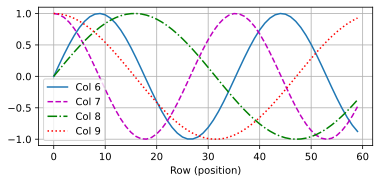

In [48]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In [49]:
# 编码器
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, 
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, use_bias = False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, 
                                             ffn_num_hiddens, num_heads, dropout, use_bias
                                            )
                                )
    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [50]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype = torch.long), valid_len).shape

torch.Size([2, 100, 24])

In [51]:
# 解码器块
class DecoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
                key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis = 1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(1, num_steps + 1, device = X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [52]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

当模型处于训练状态时，需要限制解码器的注意力范围，使其只能关注到当前位置及之前的位置（防止 “偷看” 未来的序列信息，这在语言生成等任务中至关重要）。
对于批次中每个样本的第i个位置（从 0 开始），允许关注的位置范围是[0, i]（共i+1个位置）。这种限制确保了解码器在训练时遵循 “自回归” 特性，只能基于已生成的内容预测下一个元素。

因为训练的时候，解码器分析了整个序列长度，编码器需要使用dec_valid_lens来限制看到的序列长度，来训练

当模型用于推理（生成新序列）时，通常不需要预设固定的有效长度限制，而是采用 “逐 token 生成” 的方式：

In [53]:
# 解码器
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+ str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [54]:
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError
class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError
class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss
        
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()	# 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss 0.031, 16349.4 tokens/sec on cuda:0


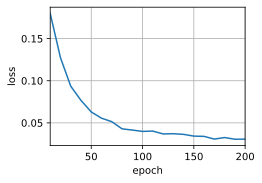

In [55]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [56]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j’ai perdu .,  bleu 0.687
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


In [57]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

当进行最后一个英语到法语的句子翻译工作时，让我们可视化Transformer的注意力权重。编码器自注意力权重的形状为（编码器层数，注意力头数，num_steps或查询的数目，num_steps或“键－值”对的数目）

注意力权重的维度

 第一个维度：编码器层数（Encoder Layers）

 第二个维度：注意力头数（Attention Heads）
 
 第三个维度：查询数目（Query Count）= 输入序列长度（num_steps）
 
 第四个维度：键 - 值对数目（Key-Value Count）= 输入序列长度（num_steps）

 因为这里取的是第一个句子， 其实最前面还有个 batch_size 的维度

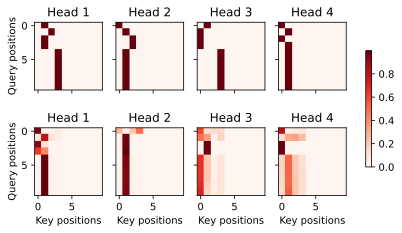

In [58]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))